In [4]:
%%html 
<link href="https://fonts.googleapis.com/css?family=Open+Sans" rel="stylesheet">
<style>#notebook-container{font-size: 13pt;font-family:'Open Sans', sans-serif;} div.text_cell{max-width: 104ex;}</style>

In [5]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import mglearn
from IPython.display import display
from sklearn.model_selection import train_test_split

# Kernelized Support Vector Machines (SVMs)

We explored the use of linear support vector machines for classification. Kernelized support vector machines are an extension that allows for more complex models that are not defined simply by hyperplanes in the input space.

While there are support vector machines for classification and regression, we will restrict ourselves to the classification case, implemented in `SVC`. The same concepts apply to regression implemented in `SVR`.

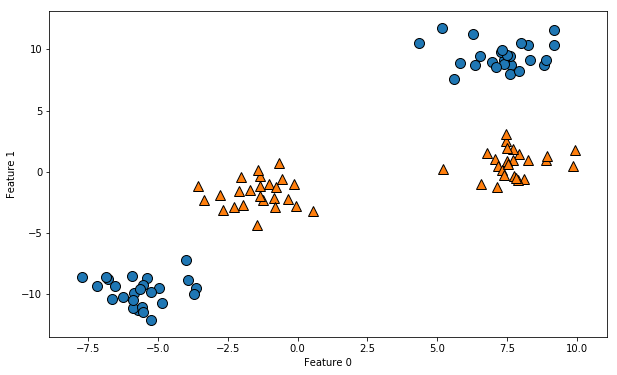

In [11]:
from sklearn.datasets import make_blobs

X, y = make_blobs(centers=4, random_state=8)
y = y % 2

plt.figure(figsize=(10,6))
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

A linear model for classification can only seperate points using a line, and will not be able to do a very good job on this dataset.

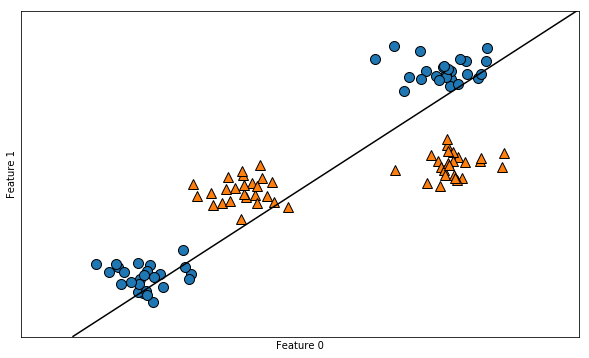

In [14]:
from sklearn.svm import LinearSVC
linear_svm = LinearSVC().fit(X, y)

plt.figure(figsize=(10,6))
mglearn.plots.plot_2d_separator(linear_svm, X)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

Let's expand the set of input features by adding `feature`$^2$, the square of the second feature, as a new feature.

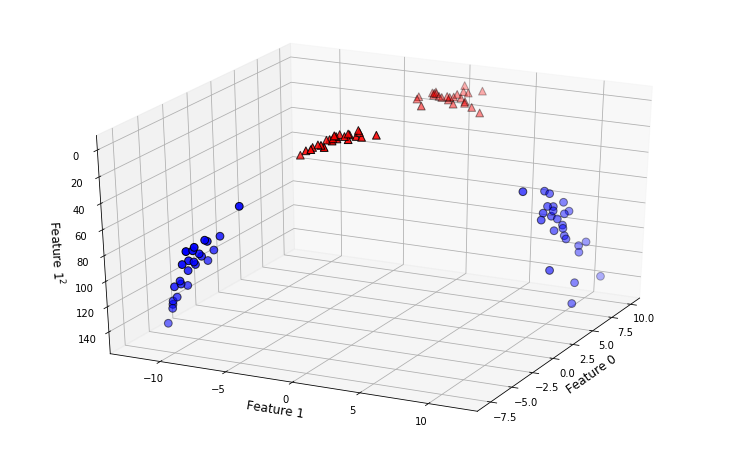

In [29]:
X_new = np.hstack([X, X[:, 1:] ** 2])

from mpl_toolkits.mplot3d import Axes3D, axes3d
figure = plt.figure(figsize=(10,6))

ax = Axes3D(figure, elev=-152, azim=-26)

mask = y == 0
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel('Feature 0', fontsize='large')
ax.set_ylabel('Feature 1', fontsize='large')
ax.set_zlabel('Feature 1$^2$', fontsize='large');

In the new representation of the data, it is now indeed possible to seperate the two classes using a linear model, a plane in three dimensions.

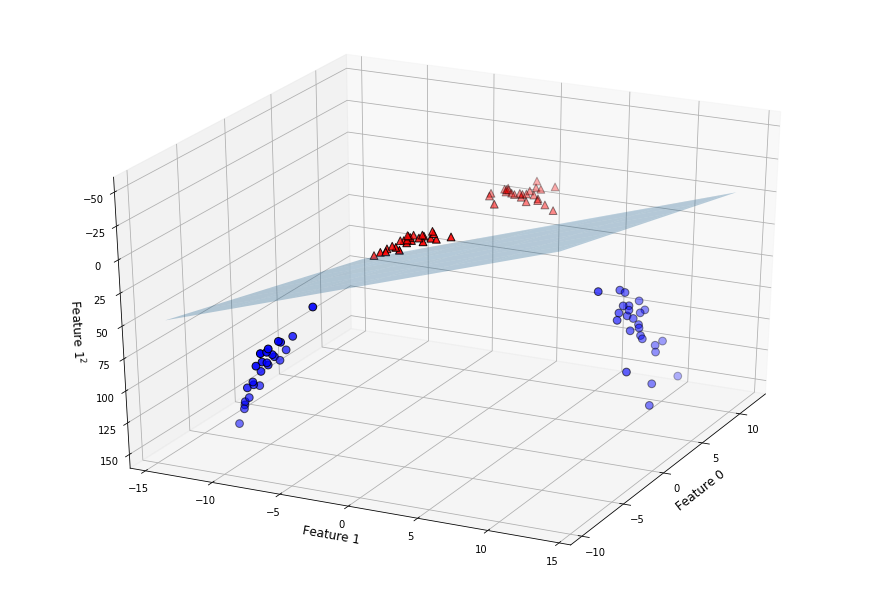

In [37]:
linear_svm_3d = LinearSVC().fit(X_new, y)
coef, intercept = linear_svm_3d.coef_.ravel(), linear_svm_3d.intercept_

figure = plt.figure(figsize=(12,8))
ax = Axes3D(figure, elev=-152, azim=-26)
xx = np.linspace(X_new[:, 0].min() - 2, X_new[:, 0].max() + 2, 50)
yy = np.linspace(X_new[:, 1].min() - 2, X_new[:, 1].max() + 2, 50)

XX, YY = np.meshgrid(xx, yy)
ZZ = (coef[0] * XX + coef[1] * YY + intercept) / -coef[2]
ax.plot_surface(XX, YY, ZZ, rstride=8, cstride=8, alpha=0.3)
ax.scatter(X_new[mask, 0], X_new[mask, 1], X_new[mask, 2], c='b', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.scatter(X_new[~mask, 0], X_new[~mask, 1], X_new[~mask, 2], c='r', marker='^', cmap=mglearn.cm2, s=60, edgecolor='k')
ax.set_xlabel('Feature 0', fontsize='large')
ax.set_ylabel('Feature 1', fontsize='large')
ax.set_zlabel('Feature 1$^2$', fontsize='large');

As a function of the original features, the linear SVM model is not actually linear anymore. It is not a line, but more of an ellipse.

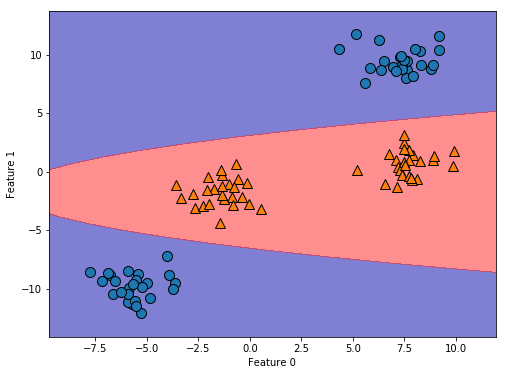

In [40]:
ZZ = YY ** 2
dec = linear_svm_3d.decision_function(np.c_[XX.ravel(), YY.ravel(), ZZ.ravel()])
plt.figure(figsize=(8,6))
plt.contourf(XX, YY, dec.reshape(XX.shape), levels=[dec.min(), 0, dec.max()], cmap=mglearn.cm2, alpha=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

## The Kernel Trick

There is a clever mathematical trick that allows us to learn a classifier in a higher-dimensional space without actually computing the new, possibly very large representation. This is known as the _kernel trick_, and it works by directly computing the distance (more precisely, the scalar-products) of the data points for the expanded feature representation, without ever actually computing the expansion.

There are two ways to map your data into a higher-dimensional space that are commonly used with support vector machines: the polynomial kernel `poly`, which computes all possible polynomials up to a certain degree of the original features; and the radial basis function (RBF) kernel `rbf`, also known as the Gaussian kernel. One way to explain the Gaussian kernel is that it considers all possible polynomials of all degrees, but the importance of the feature decreases for higher degrees (this follows from the Taylor expansion of the exponential map).

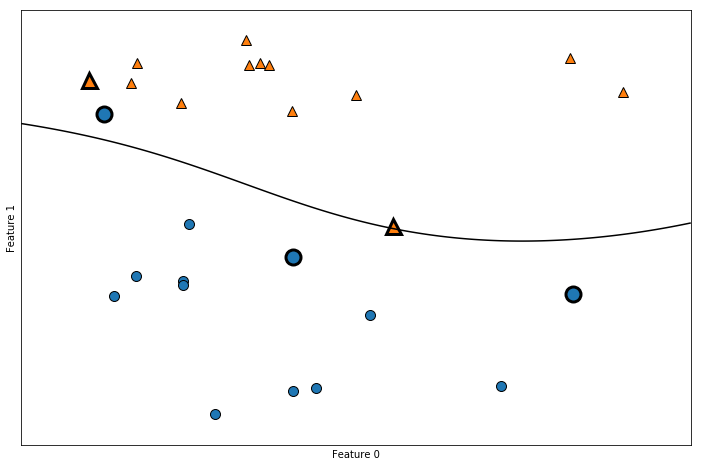

In [44]:
from sklearn.svm import SVC
X, y = mglearn.tools.make_handcrafted_dataset()
svm = SVC(kernel='rbf', C=10, gamma=0.1).fit(X, y)
plt.figure(figsize=(12,8))
mglearn.plots.plot_2d_separator(svm, X, eps=0.5)
mglearn.discrete_scatter(X[:, 0], X[:, 1], y)
sv = svm.support_vectors_
sv_labels = svm.dual_coef_.ravel() > 0
mglearn.discrete_scatter(sv[:, 0], sv[:, 1], sv_labels, s=15, markeredgewidth=3)
plt.xlabel("Feature 0")
plt.ylabel("Feature 1");

We adjusted two parameters here, the `C` parameter and the `gamma` parameter.

## Tuning SVM parameters

Let's have a look at what happens when we vary these parameters.

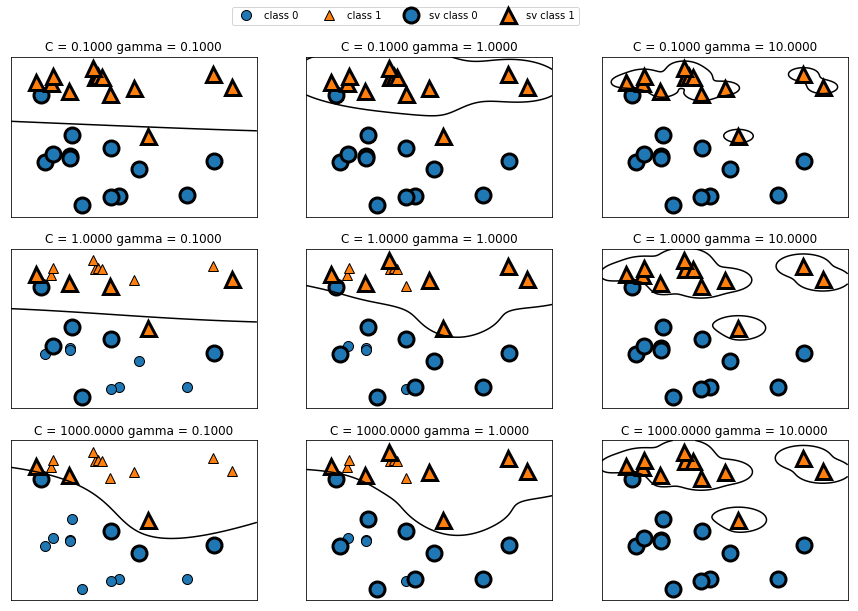

In [51]:
fig, axes = plt.subplots(3, 3, figsize=(15,10))

for ax, C in zip(axes, [-1, 0, 3]):
    for a, gamma in zip(ax, range(-1,2)):
        mglearn.plots.plot_svm(log_C=C, log_gamma=gamma, ax=a)

axes[0, 0].legend(["class 0", "class 1", "sv class 0", "sv class 1"], ncol=4, loc=(0.9, 1.2));

Going from left to right, we increase the value of the parameter `gamma`. A small `gamma` means a large radius for the Gaussian kernel, which means that many points are considered close by. This is reflected in very smooth decision boundaries on the left, and boundaries that focus more on single points further to the right. A low value of `gamma` means that the decision boundary will vary slowly, which yields a model of low complexity, while a high value of `gamma` yields a more complex model.

Going from top to bottom, we increase the `C` parameter. As with the linear models, a small `C` means a very restricted model, where each data point can only have very limited influence, with missclassified points barely having any influence on the line. Increasing `C` allows these points to have a stronger influence on the model and makes the decision boundary bend to correctly classify them.

Let's appy the RBF kernel to the Breast Cancer dataset. By default, `C=1` and `gamma=1/n_features`.

In [52]:
from sklearn.datasets import load_breast_cancer
cancer = load_breast_cancer()

In [53]:
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, random_state=0)

svc = SVC()
svc.fit(X_train, y_train)

print('Accuracy on training set: {:.3f}'.format(svc.score(X_train, y_train)))
print('Accuracy on test set: {:.3f}'.format(svc.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.629


The model overfits quite substantially, with a perfect score on the training set and only 63% accuracy on the test set.

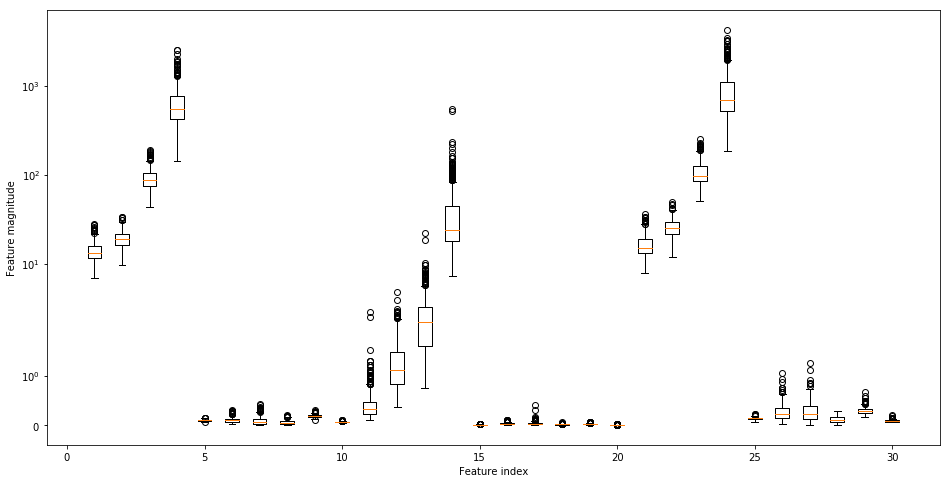

In [59]:
plt.figure(figsize=(16,8))
plt.boxplot(X_train, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude");

From this plot we can determine that features in the Breast Cancer dataset are of completely different orders of magnitude. This can be somewhat of a problem for other models (like linear models), but it has devastating effects for the kernel SVM.

## Preprocessing data for SVMs

One way to resolve this problem is by rescaling each feature so that they are all on approximately the same scale.

In [61]:
min_on_training = X_train.min(axis=0)
range_on_training = (X_train - min_on_training).max(axis=0)

X_train_scaled = (X_train - min_on_training) / range_on_training

print("Minimum for each feature \n:{}".format(X_train_scaled.min(axis=0)))
print("Maximum for each feature \n:{}".format(X_train_scaled.max(axis=0)))

Minimum for each feature 
:[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
Maximum for each feature 
:[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.]


In [62]:
X_test_scaled = (X_test - min_on_training) / range_on_training

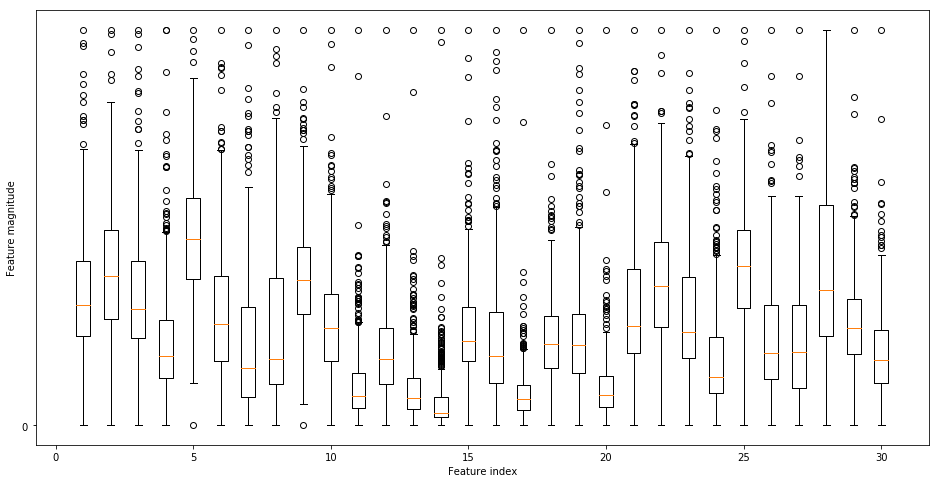

In [66]:
plt.figure(figsize=(16,8))
plt.boxplot(X_train_scaled, manage_xticks=False)
plt.yscale("symlog")
plt.xlabel("Feature index")
plt.ylabel("Feature magnitude");

In [64]:
svc = SVC()
svc.fit(X_train_scaled, y_train)

print('Accuracy on training set: {:.3f}'.format(svc.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.3f}'.format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.948
Accuracy on test set: 0.951


Scaling the data made a huge difference! Now we are actually in an underfitting regime, where training and test set performance are quite similar but less close to 100% accuracy.

In [65]:
svc = SVC(C=1000)
svc.fit(X_train_scaled, y_train)

print('Accuracy on training set: {:.3f}'.format(svc.score(X_train_scaled, y_train)))
print('Accuracy on test set: {:.3f}'.format(svc.score(X_test_scaled, y_test)))

Accuracy on training set: 0.988
Accuracy on test set: 0.972


## Strengths

Kernelized support vector machines are powerful models and perform well on a variety of datasets. SVMs allow for complex decision boundaries, even if the data has only a few features. They work well on low-dimensional and high-dimensional data, but don't scale very well with the number of samples. Running an SVM on data with up to 10,000 samples might work well, but working with datasets of size 100,000 or more can become challenging in terms of runtime and memory usage.

## Weaknesses

A downside of SVMs is that they require careful preprocessing of the data and tuning of the parameters. This is why, these days, most people instead use tree-based models such as random forests or gradient boosting. Furthermore, SVM models are harder to inspect; it can be difficult to understand why a particular predicion was made, and it might be tricky to explain the model to a nonexpert.